RESOLUTION CURRICULUM LEARNING (RCL) - MobileNetV3-Large
Device: cuda
Mixed Precision: True
Seed: 42

RCL Phases:
  phase1: 128x128, 5 epochs, LR=0.001, BS=32
  phase2: 192x192, 7 epochs, LR=0.0005, BS=32
  phase3: 224x224, 8 epochs, LR=0.0001, BS=32


[1/5] Computing class weights...
Class weights:
  akiec: 0.9203
  bcc: 0.5659
  bkl: 0.2646
  df: 2.8775
  mel: 0.2643
  nv: 0.0436
  vasc: 2.0637

[2/5] Initializing model...
Model loaded: MobileNetV3-Large
Total parameters: 4,210,999

[3/5] Setting up optimizer...
Optimizer: AdamW (weight_decay=0.0001)

[4/5] Starting RCL training...

STARTING PHASE1: 128x128, 5 epochs
Backbone: FROZEN (training classifier only)
Epoch 1/5 | Train Loss: 1.7202 | Val Loss: 1.4367 | Val Macro-F1: 0.2842 | Val MEL Recall: 0.3526 | Time: 49.0s
  → Best model saved (Macro-F1: 0.2842)
Epoch 2/5 | Train Loss: 1.5312 | Val Loss: 1.1407 | Val Macro-F1: 0.3590 | Val MEL Recall: 0.5087 | Time: 46.0s
  → Best model saved (Macro-F1: 0.3590)
Epoch 3/5 | Train Loss: 1

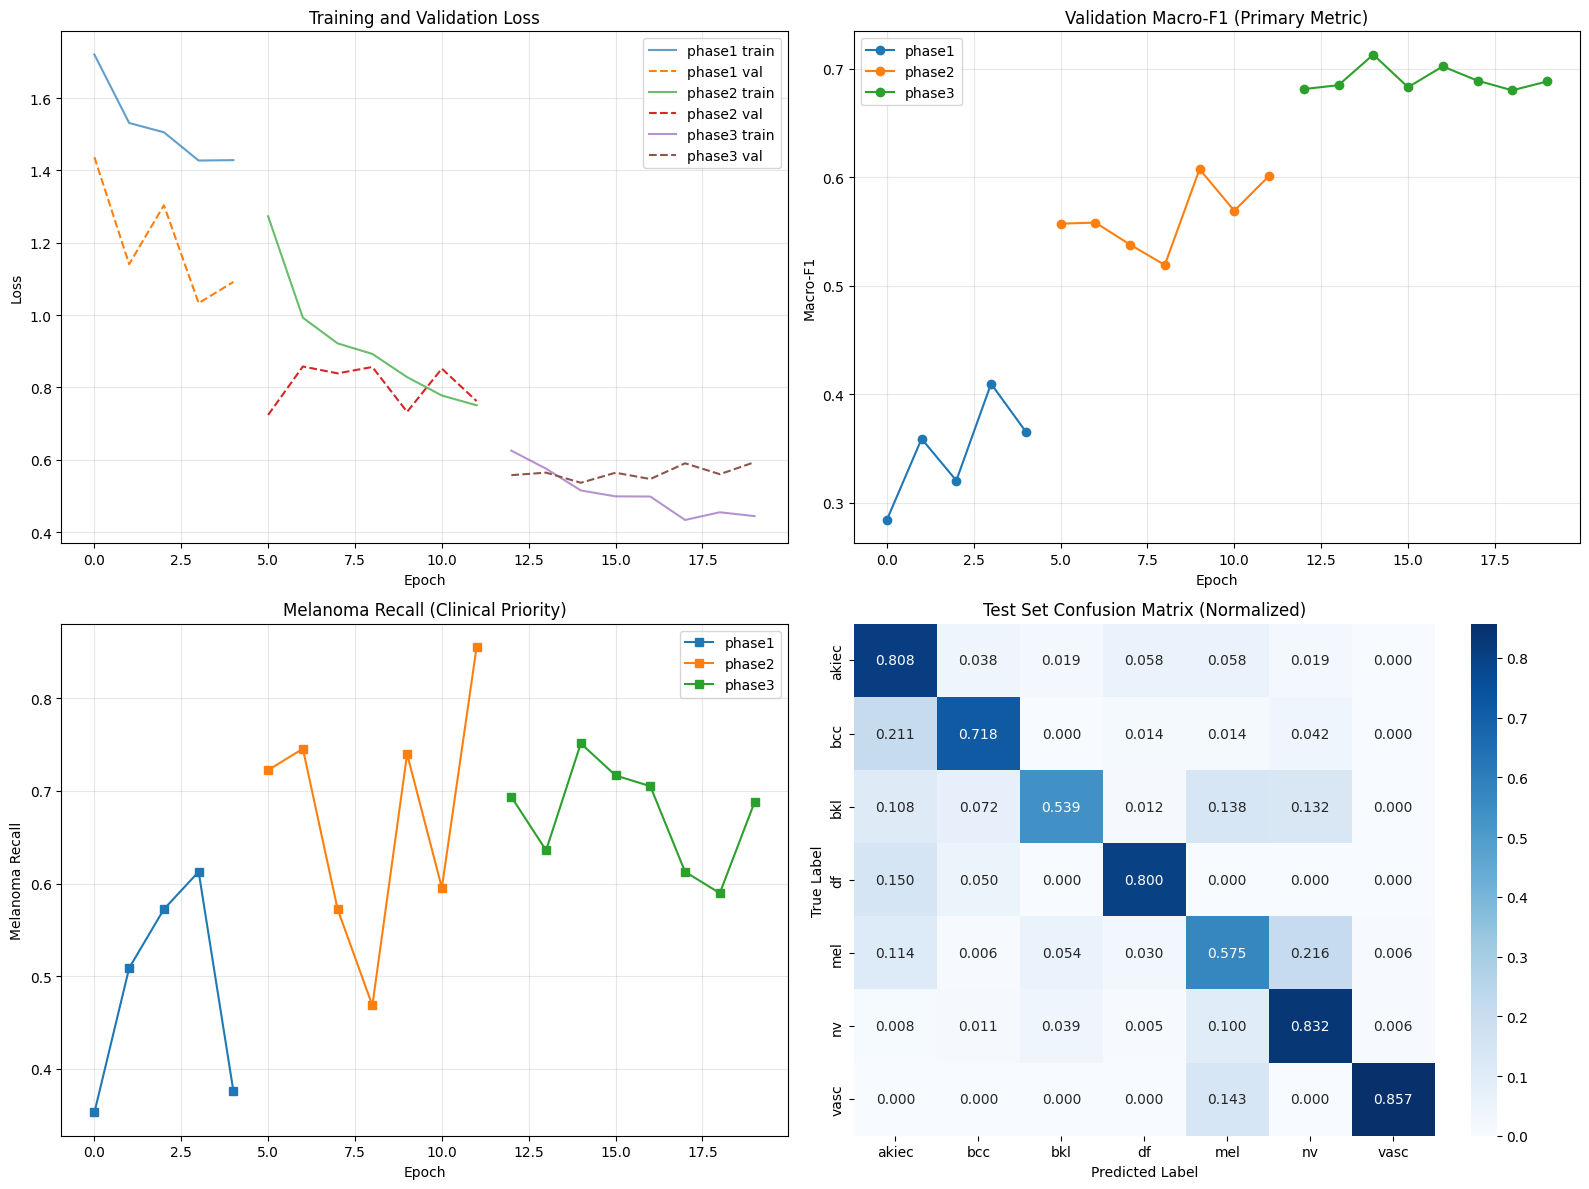

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Import shared infrastructure from Portion 2
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix

# ============================================================================
# REPRODUCE PORTION 2 ESSENTIAL FUNCTIONS (to avoid import errors)
# ============================================================================

import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset

# Constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
CLASS_NAMES = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}

IMAGE_DIR_1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
IMAGE_DIR_2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

def set_seed(seed: int = 42):
    """Set all random seeds for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class HAM10000Dataset(Dataset):
    """HAM10000 Dataset with dynamic resolution."""
    
    def __init__(self, csv_path: str, img_dir_1: str = IMAGE_DIR_1, 
                 img_dir_2: str = IMAGE_DIR_2, img_size: int = 224, 
                 transform: Optional[A.Compose] = None, is_training: bool = False):
        self.df = pd.read_csv(csv_path)
        self.img_dir_1 = Path(img_dir_1)
        self.img_dir_2 = Path(img_dir_2)
        self.img_size = img_size
        self.is_training = is_training
        
        if transform is not None:
            self.transform = transform
        else:
            self.transform = self._get_default_transform()
        
        self.df['label'] = self.df['dx'].map(CLASS_TO_IDX)
    
    def _get_default_transform(self) -> A.Compose:
        if self.is_training:
            return A.Compose([
                A.Resize(self.img_size, self.img_size),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
                A.OneOf([
                    A.GaussNoise(var_limit=(10.0, 50.0)),
                    A.GaussianBlur(blur_limit=(3, 7)),
                    A.MedianBlur(blur_limit=5),
                ], p=0.3),
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
                A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                ToTensorV2()
            ])
        else:
            return A.Compose([
                A.Resize(self.img_size, self.img_size),
                A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                ToTensorV2()
            ])
    
    def _load_image(self, image_id: str) -> np.ndarray:
        img_path_1 = self.img_dir_1 / f"{image_id}.jpg"
        img_path_2 = self.img_dir_2 / f"{image_id}.jpg"
        
        if img_path_1.exists():
            img_path = img_path_1
        elif img_path_2.exists():
            img_path = img_path_2
        else:
            raise FileNotFoundError(f"Image not found: {image_id}")
        
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        row = self.df.iloc[idx]
        image = self._load_image(row['image_id'])
        transformed = self.transform(image=image)
        image = transformed['image']
        label = int(row['label'])
        return image, label

def compute_class_weights(csv_path: str, method: str = 'inverse') -> torch.Tensor:
    """Compute class weights for imbalanced dataset."""
    df = pd.read_csv(csv_path)
    df['label'] = df['dx'].map(CLASS_TO_IDX)
    class_counts = np.bincount(df['label'], minlength=len(CLASS_NAMES))
    
    if method == 'inverse':
        weights = 1.0 / (class_counts + 1e-6)
        weights = weights / weights.sum() * len(CLASS_NAMES)
    elif method == 'effective':
        beta = 0.9999
        effective_num = 1.0 - np.power(beta, class_counts)
        weights = (1.0 - beta) / (effective_num + 1e-6)
        weights = weights / weights.sum() * len(CLASS_NAMES)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return torch.FloatTensor(weights)

class AverageMeter:
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """Compute evaluation metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    per_class_recall = recall_score(y_true, y_pred, average=None, labels=range(len(CLASS_NAMES)))
    
    mel_idx = CLASS_TO_IDX['mel']
    melanoma_recall = per_class_recall[mel_idx]
    
    metrics = {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'melanoma_recall': melanoma_recall
    }
    
    for i, cls in enumerate(CLASS_NAMES):
        metrics[f'{cls}_recall'] = per_class_recall[i]
    
    return metrics

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    # Paths
    TRAIN_CSV = '/kaggle/input/data-prime/train (1).csv'
    VAL_CSV = '/kaggle/input/data-prime/val.csv'
    TEST_CSV = '/kaggle/input/data-prime/test (1).csv'
    OUTPUT_DIR = '/kaggle/working/rcl_outputs'
    
    # Training
    SEED = 42
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_WORKERS = 2
    
    # RCL Phases
    PHASES = [
        {'name': 'phase1', 'img_size': 128, 'epochs': 5, 'batch_size': 32, 'lr': 1e-3},
        {'name': 'phase2', 'img_size': 192, 'epochs': 7, 'batch_size': 32, 'lr': 5e-4},
        {'name': 'phase3', 'img_size': 224, 'epochs': 8, 'batch_size': 32, 'lr': 1e-4},
    ]
    
    # Model
    NUM_CLASSES = 7
    
    # Optimizer
    WEIGHT_DECAY = 1e-4
    
    # Mixed Precision
    USE_AMP = True

cfg = Config()

print("=" * 80)
print("RESOLUTION CURRICULUM LEARNING (RCL) - MobileNetV3-Large")
print("=" * 80)
print(f"Device: {cfg.DEVICE}")
print(f"Mixed Precision: {cfg.USE_AMP}")
print(f"Seed: {cfg.SEED}")
print("\nRCL Phases:")
for phase in cfg.PHASES:
    print(f"  {phase['name']}: {phase['img_size']}x{phase['img_size']}, "
          f"{phase['epochs']} epochs, LR={phase['lr']}, BS={phase['batch_size']}")
print("=" * 80)
print()

# Set seed
set_seed(cfg.SEED)

# Create output directory
Path(cfg.OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# ============================================================================
# MODEL DEFINITION
# ============================================================================

class MobileNetV3Classifier(nn.Module):
    """MobileNetV3-Large for HAM10000 classification."""
    
    def __init__(self, num_classes: int = 7, pretrained: bool = True):
        super().__init__()
        
        # Load pretrained MobileNetV3-Large
        from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
        
        if pretrained:
            weights = MobileNet_V3_Large_Weights.IMAGENET1K_V1
            self.backbone = mobilenet_v3_large(weights=weights)
        else:
            self.backbone = mobilenet_v3_large(weights=None)
        
        # Replace classifier
        in_features = self.backbone.classifier[0].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, 1280),
            nn.Hardswish(inplace=True),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(1280, num_classes)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)
    
    def freeze_backbone(self):
        """Freeze all layers except classifier."""
        for param in self.backbone.features.parameters():
            param.requires_grad = False
    
    def unfreeze_backbone(self, unfreeze_from_layer: Optional[int] = None):
        """Unfreeze backbone layers."""
        if unfreeze_from_layer is None:
            # Unfreeze all
            for param in self.backbone.features.parameters():
                param.requires_grad = True
        else:
            # Unfreeze from specific layer
            for i, layer in enumerate(self.backbone.features):
                if i >= unfreeze_from_layer:
                    for param in layer.parameters():
                        param.requires_grad = True

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_one_epoch(model: nn.Module, dataloader: DataLoader, criterion: nn.Module,
                   optimizer: optim.Optimizer, device: torch.device, 
                   scaler: GradScaler, use_amp: bool = True) -> Dict[str, float]:
    """Train for one epoch."""
    model.train()
    loss_meter = AverageMeter()
    
    all_preds = []
    all_labels = []
    
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        if use_amp:
            with autocast():
                logits = model(images)
                loss = criterion(logits, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
        
        loss_meter.update(loss.item(), images.size(0))
        
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
    
    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    metrics = compute_metrics(y_true, y_pred)
    metrics['loss'] = loss_meter.avg
    
    return metrics

@torch.no_grad()
def validate(model: nn.Module, dataloader: DataLoader, criterion: nn.Module,
            device: torch.device, use_amp: bool = True) -> Dict[str, float]:
    """Validate model."""
    model.eval()
    loss_meter = AverageMeter()
    
    all_preds = []
    all_labels = []
    
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        if use_amp:
            with autocast():
                logits = model(images)
                loss = criterion(logits, labels)
        else:
            logits = model(images)
            loss = criterion(logits, labels)
        
        loss_meter.update(loss.item(), images.size(0))
        
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
    
    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    metrics = compute_metrics(y_true, y_pred)
    metrics['loss'] = loss_meter.avg
    
    return metrics, y_true, y_pred

# ============================================================================
# RCL TRAINING PIPELINE
# ============================================================================

def train_rcl_phase(model: nn.Module, phase_config: Dict, 
                   train_csv: str, val_csv: str,
                   class_weights: torch.Tensor,
                   optimizer: optim.Optimizer,
                   device: torch.device,
                   history: List[Dict],
                   phase_idx: int) -> nn.Module:
    """Train one RCL phase."""
    
    phase_name = phase_config['name']
    img_size = phase_config['img_size']
    epochs = phase_config['epochs']
    batch_size = phase_config['batch_size']
    lr = phase_config['lr']
    
    print(f"\n{'=' * 80}")
    print(f"STARTING {phase_name.upper()}: {img_size}x{img_size}, {epochs} epochs")
    print(f"{'=' * 80}")
    
    # Create datasets and dataloaders for this phase
    train_dataset = HAM10000Dataset(train_csv, img_size=img_size, is_training=True)
    val_dataset = HAM10000Dataset(val_csv, img_size=img_size, is_training=False)
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=cfg.NUM_WORKERS, pin_memory=True, drop_last=True,
        worker_init_fn=lambda worker_id: np.random.seed(cfg.SEED + worker_id)
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=cfg.NUM_WORKERS, pin_memory=True
    )
    
    # Update learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    # Gradual unfreezing strategy
    if phase_idx == 0:
        # Phase 1: Freeze backbone
        model.freeze_backbone()
        print("Backbone: FROZEN (training classifier only)")
    elif phase_idx == 1:
        # Phase 2: Unfreeze top layers
        model.unfreeze_backbone(unfreeze_from_layer=10)
        print("Backbone: PARTIALLY UNFROZEN (from layer 10)")
    else:
        # Phase 3: Unfreeze all
        model.unfreeze_backbone()
        print("Backbone: FULLY UNFROZEN")
    
    # Loss function
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    
    # AMP scaler
    scaler = GradScaler() if cfg.USE_AMP else None
    
    # Training loop
    best_val_f1 = 0.0
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # Train
        train_metrics = train_one_epoch(
            model, train_loader, criterion, optimizer, device, scaler, cfg.USE_AMP
        )
        
        # Validate
        val_metrics, _, _ = validate(model, val_loader, criterion, device, cfg.USE_AMP)
        
        epoch_time = time.time() - start_time
        
        # Log
        log_entry = {
            'phase': phase_name,
            'epoch': epoch + 1,
            'img_size': img_size,
            'train_loss': train_metrics['loss'],
            'train_acc': train_metrics['accuracy'],
            'train_macro_f1': train_metrics['macro_f1'],
            'val_loss': val_metrics['loss'],
            'val_acc': val_metrics['accuracy'],
            'val_macro_f1': val_metrics['macro_f1'],
            'val_mel_recall': val_metrics['melanoma_recall'],
            'epoch_time': epoch_time
        }
        
        # Add per-class recalls
        for cls in CLASS_NAMES:
            log_entry[f'val_{cls}_recall'] = val_metrics[f'{cls}_recall']
        
        history.append(log_entry)
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_metrics['loss']:.4f} | "
              f"Val Loss: {val_metrics['loss']:.4f} | "
              f"Val Macro-F1: {val_metrics['macro_f1']:.4f} | "
              f"Val MEL Recall: {val_metrics['melanoma_recall']:.4f} | "
              f"Time: {epoch_time:.1f}s")
        
        # Save best model
        if val_metrics['macro_f1'] > best_val_f1:
            best_val_f1 = val_metrics['macro_f1']
            checkpoint_path = Path(cfg.OUTPUT_DIR) / f'{phase_name}_best.pth'
            torch.save({
                'epoch': epoch + 1,
                'phase': phase_name,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_macro_f1': best_val_f1,
                'val_metrics': val_metrics
            }, checkpoint_path)
            print(f"  → Best model saved (Macro-F1: {best_val_f1:.4f})")
    
    # Save final checkpoint
    final_checkpoint_path = Path(cfg.OUTPUT_DIR) / f'{phase_name}_final.pth'
    torch.save({
        'phase': phase_name,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, final_checkpoint_path)
    
    print(f"\n{phase_name.upper()} COMPLETE | Best Val Macro-F1: {best_val_f1:.4f}")
    
    return model

# ============================================================================
# MAIN TRAINING PIPELINE
# ============================================================================

def main():
    print("\n[1/5] Computing class weights...")
    class_weights = compute_class_weights(cfg.TRAIN_CSV, method='inverse')
    print("Class weights:")
    for cls, w in zip(CLASS_NAMES, class_weights):
        print(f"  {cls}: {w:.4f}")
    
    print("\n[2/5] Initializing model...")
    model = MobileNetV3Classifier(num_classes=cfg.NUM_CLASSES, pretrained=True)
    model = model.to(cfg.DEVICE)
    print(f"Model loaded: MobileNetV3-Large")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    print("\n[3/5] Setting up optimizer...")
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=cfg.WEIGHT_DECAY)
    print(f"Optimizer: AdamW (weight_decay={cfg.WEIGHT_DECAY})")
    
    print("\n[4/5] Starting RCL training...")
    history = []
    
    for phase_idx, phase_config in enumerate(cfg.PHASES):
        model = train_rcl_phase(
            model=model,
            phase_config=phase_config,
            train_csv=cfg.TRAIN_CSV,
            val_csv=cfg.VAL_CSV,
            class_weights=class_weights,
            optimizer=optimizer,
            device=cfg.DEVICE,
            history=history,
            phase_idx=phase_idx
        )
    
    print("\n[5/5] Saving training history...")
    history_df = pd.DataFrame(history)
    history_df.to_csv(Path(cfg.OUTPUT_DIR) / 'training_history.csv', index=False)
    print(f"Training history saved to {cfg.OUTPUT_DIR}/training_history.csv")
    
    # ========================================================================
    # FINAL EVALUATION ON TEST SET
    # ========================================================================
    
    print("\n" + "=" * 80)
    print("FINAL EVALUATION ON TEST SET")
    print("=" * 80)
    
    # Load best phase3 model
    best_checkpoint = torch.load(
    Path(cfg.OUTPUT_DIR) / 'phase3_best.pth',
    map_location=cfg.DEVICE,
    weights_only=False)

    model.load_state_dict(best_checkpoint['model_state_dict'])
    
    # Create test dataloader
    test_dataset = HAM10000Dataset(cfg.TEST_CSV, img_size=224, is_training=False)
    test_loader = DataLoader(
        test_dataset, batch_size=32, shuffle=False,
        num_workers=cfg.NUM_WORKERS, pin_memory=True
    )
    
    # Evaluate
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(cfg.DEVICE))
    test_metrics, y_true, y_pred = validate(model, test_loader, criterion, cfg.DEVICE, cfg.USE_AMP)
    
    print("\nTest Set Results:")
    print(f"  Accuracy:        {test_metrics['accuracy']:.4f}")
    print(f"  Macro-F1:        {test_metrics['macro_f1']:.4f}")
    print(f"  Melanoma Recall: {test_metrics['melanoma_recall']:.4f}")
    print("\nPer-class Recall:")
    for cls in CLASS_NAMES:
        marker = " ★" if cls == 'mel' else ""
        print(f"  {cls}: {test_metrics[f'{cls}_recall']:.4f}{marker}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(CLASS_NAMES)))
    cm_normalized = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)
    
    print("\nConfusion Matrix (normalized):")
    print("       " + "  ".join([f"{cls:>6}" for cls in CLASS_NAMES]))
    for i, cls in enumerate(CLASS_NAMES):
        row = f"{cls:>6} " + "  ".join([f"{cm_normalized[i, j]:>6.3f}" for j in range(len(CLASS_NAMES))])
        print(row)
    
    # Save test results
    test_results = {
        'test_accuracy': test_metrics['accuracy'],
        'test_macro_f1': test_metrics['macro_f1'],
        'test_melanoma_recall': test_metrics['melanoma_recall']
    }
    for cls in CLASS_NAMES:
        test_results[f'test_{cls}_recall'] = test_metrics[f'{cls}_recall']
    
    pd.DataFrame([test_results]).to_csv(Path(cfg.OUTPUT_DIR) / 'test_results.csv', index=False)
    
    # ========================================================================
    # VISUALIZATION
    # ========================================================================
    
    print("\n[6/6] Generating training curves...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Loss curves
    for phase_name in ['phase1', 'phase2', 'phase3']:
        phase_data = history_df[history_df['phase'] == phase_name]
        axes[0, 0].plot(phase_data.index, phase_data['train_loss'], label=f'{phase_name} train', alpha=0.7)
        axes[0, 0].plot(phase_data.index, phase_data['val_loss'], label=f'{phase_name} val', linestyle='--')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Macro-F1
    for phase_name in ['phase1', 'phase2', 'phase3']:
        phase_data = history_df[history_df['phase'] == phase_name]
        axes[0, 1].plot(phase_data.index, phase_data['val_macro_f1'], label=f'{phase_name}', marker='o')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Macro-F1')
    axes[0, 1].set_title('Validation Macro-F1 (Primary Metric)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Melanoma Recall
    for phase_name in ['phase1', 'phase2', 'phase3']:
        phase_data = history_df[history_df['phase'] == phase_name]
        axes[1, 0].plot(phase_data.index, phase_data['val_mel_recall'], label=f'{phase_name}', marker='s')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Melanoma Recall')
    axes[1, 0].set_title('Melanoma Recall (Clinical Priority)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Confusion Matrix
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1, 1])
    axes[1, 1].set_title('Test Set Confusion Matrix (Normalized)')
    axes[1, 1].set_ylabel('True Label')
    axes[1, 1].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.savefig(Path(cfg.OUTPUT_DIR) / 'training_curves.png', dpi=300, bbox_inches='tight')
    print(f"Training curves saved to {cfg.OUTPUT_DIR}/training_curves.png")
    
    print("\n" + "=" * 80)
    print("RCL TRAINING COMPLETE")
    print("=" * 80)
    print(f"All outputs saved to: {cfg.OUTPUT_DIR}")
    print("Files generated:")
    print("  - phase1_best.pth, phase1_final.pth")
    print("  - phase2_best.pth, phase2_final.pth")
    print("  - phase3_best.pth, phase3_final.pth")
    print("  - training_history.csv")
    print("  - test_results.csv")
    print("  - training_curves.png")
    print("=" * 80)

# ============================================================================
# EXECUTE
# ============================================================================

if __name__ == '__main__':
    main()